# Model Comparison in The Domain of Brain Tumor Image Classification  
For our final project for Spring 2025, CS 4644 - Deep Learning, we analyze and compare the results from three unique models:  
1. 3D CNN - Turning 2D images into 3D datapoints to reconstruct a full brain image.  
2. ResNet18 - Applying transfer learning by taking a pretrained ResNet-18 model (trained on ImageNet) and adapting it to MRI scans through the fine-tuning of a final fully connected layer.  
3. Inception - Applying transfer learning in the same way as ResNet, but for another popular and successful model.  
  
The following code allows the reader to experiment with these 3 models and observe their results.

# Step 0: Get necessary imports, set global variables, and setup dataset

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
%cd /content/drive/MyDrive/CS4644/TumorTrace/

/content/drive/MyDrive/CS4644/TumorTrace


In [4]:
# Basic imports
import os
import sys
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))
import torch
from PIL import Image
import matplotlib.pyplot as plt

from src import (
    get_optimizer,
    Trainer,
)
from src.models import (
    CNN_3D,
    MyResNet,
    MyInception
)
from data.data_transforms import (
    get_fundamental_transforms,
    get_fundamental_normalization_transforms,
    get_fundamental_augmentation_transforms,
    get_all_transforms,
)
from utils.confusion_matrix import (
    generate_confusion_data,
    generate_confusion_matrix,
    plot_confusion_matrix,
    get_pred_images_for_target,
    generate_and_plot_confusion_matrix,
)
from utils.utils import save_trained_model_weights
from utils.dataset_utils import prepare_dataset

#Folder paths
raw_data_path = "../data/raw/"
data_path = "../data/processed/"
model_path = "../src/models/"
results_path = "../results/"

# Global Variables
batch_size = 32
num_classes = 3 # Output classes: Pituitary, Meningioma, and Glioma Tumor
n_slices = 1 # TODO for 3D CNN: Change this if we find a pattern in the dataset for determining multiple images go to same patient

%load_ext autoreload
%autoreload 2

### Download the dataset, preprocess it, and compute statistics

In [5]:
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

mv: cannot stat 'kaggle.json': No such file or directory


In [6]:
dataset_mean, dataset_std = prepare_dataset(
    raw_data_path=raw_data_path,
    pickle_path= os.path.join(raw_data_path, "brain_tumor_mri/new_dataset/training_data.pickle"),
    processed_data_path=data_path,
    n_slices=n_slices, # TODO: figure out how many images in a row make up a 3d datapoint
)

[Info] Kaggle API token found.
[INFO] Raw data already exists. Skipping Kaggle download.
[INFO] Processed data directory already exists. Skipping conversion.
[INFO] Loading cached dataset mean and std...


# Step 1: Test 3D Convolutional Nerual Network

In [9]:
inp_size = (n_slices, 512, 512)

In [10]:
model_cnn = CNN_3D(inp_size, num_classes=num_classes)

cnn_optimizer_config = {"optimizer_type": "adam", "lr": 1e-4, "weight_decay": 1e-8} # Tune these
cnn_optimizer = get_optimizer(model_cnn, cnn_optimizer_config)

cnn_trainer = Trainer(
    data_dir=data_path,
    model=model_cnn,
    optimizer=cnn_optimizer,
    model_dir=os.path.join(model_path, "CNN_3D"),
    train_data_transforms=get_all_transforms(tuple((inp_size[1], inp_size[2])), [dataset_mean], [dataset_std]),
    val_data_transforms=get_fundamental_normalization_transforms(
        tuple((inp_size[1], inp_size[2])), [dataset_mean], [dataset_std]
    ),
    batch_size=batch_size,
    load_from_disk=False,
    cuda=torch.cuda.is_available(),
    n_slices=n_slices,
)

In [11]:
%%time
cnn_trainer.run_training_loop(num_epochs=20)

Minibatch:1 Train Loss:0.0345 Val Loss: 0.0345 Train Accuracy: 0.3750 Validation Accuracy: 0.3750
Minibatch:2 Train Loss:0.0352 Val Loss: 0.0352 Train Accuracy: 0.2812 Validation Accuracy: 0.2812
Minibatch:3 Train Loss:0.0313 Val Loss: 0.0313 Train Accuracy: 0.4062 Validation Accuracy: 0.4062
Minibatch:4 Train Loss:0.0315 Val Loss: 0.0315 Train Accuracy: 0.4688 Validation Accuracy: 0.4688
Minibatch:5 Train Loss:0.0305 Val Loss: 0.0305 Train Accuracy: 0.6562 Validation Accuracy: 0.6562
Minibatch:6 Train Loss:0.0294 Val Loss: 0.0294 Train Accuracy: 0.6250 Validation Accuracy: 0.6250
Minibatch:7 Train Loss:0.0300 Val Loss: 0.0300 Train Accuracy: 0.6250 Validation Accuracy: 0.6250
Minibatch:8 Train Loss:0.0324 Val Loss: 0.0324 Train Accuracy: 0.3750 Validation Accuracy: 0.3750
Minibatch:9 Train Loss:0.0244 Val Loss: 0.0244 Train Accuracy: 0.7500 Validation Accuracy: 0.7500
Minibatch:10 Train Loss:0.0276 Val Loss: 0.0276 Train Accuracy: 0.5938 Validation Accuracy: 0.5938
Minibatch:11 Train 

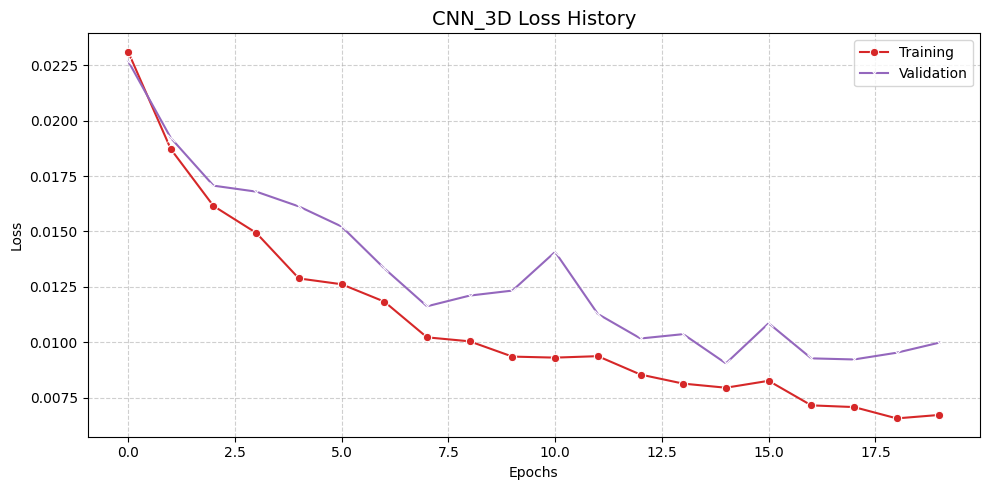

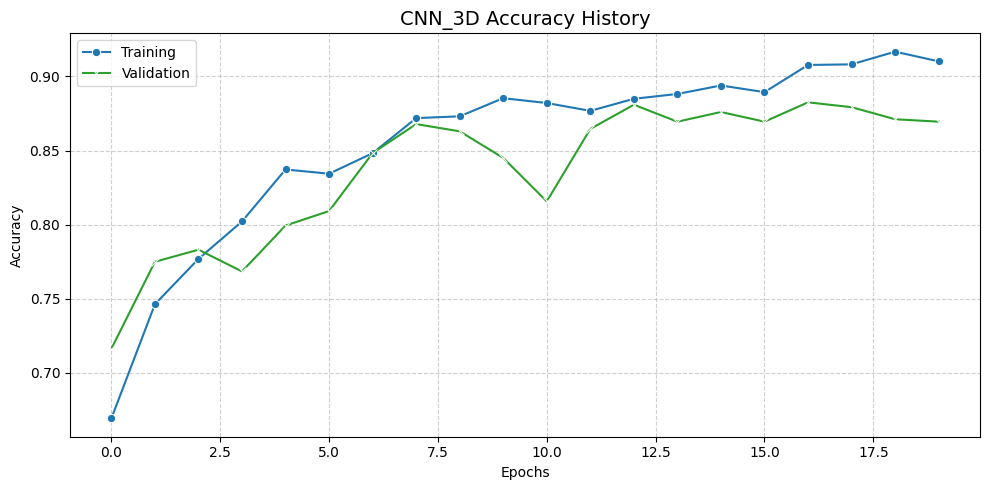

Train Accuracy = 0.9102407182444849; Validation Accuracy = 0.8694942904724382


In [12]:
cnn_trainer.plot_loss_history()
cnn_trainer.plot_accuracy()
train_accuracy = cnn_trainer.train_accuracy_history[-1]
validation_accuracy = cnn_trainer.validation_accuracy_history[-1]
print(
    "Train Accuracy = {}; Validation Accuracy = {}".format(
        train_accuracy, validation_accuracy
    )
)

In [13]:
model_path = "./src/models/"
results_path = "./results/"

save_trained_model_weights(model_cnn, out_dir=os.path.join(model_path, "CNN_3D"))

Saved training plots to ./src/models/CNN_3D/trained_CNN_3D_final.pt


# Step 2: Test ResNet Pretrained Model

In [ ]:
inp_size = (224, 224)

In [ ]:
model_resnet = MyResNet(num_classes=num_classes)

resnet_optimizer_config = {"optimizer_type": "adam", "lr": 1e-4, "weight_decay": 1e-8} # Tune these
resnet_optimizer = get_optimizer(model_resnet, resnet_optimizer_config)

resnet_trainer = Trainer(
    data_dir=data_path,
    model=model_resnet,
    optimizer=resnet_optimizer,
    model_dir=os.path.join(model_path, "ResNet"),
    train_data_transforms=get_all_transforms(inp_size, [dataset_mean], [dataset_std]),
    val_data_transforms=get_fundamental_normalization_transforms(
        inp_size, [dataset_mean], [dataset_std]
    ),
    batch_size=batch_size,
    load_from_disk=False,
    cuda=torch.cuda.is_available(),
)

In [ ]:
%%time
resnet_trainer.run_training_loop(num_epochs=20)

Minibatch:1 Train Loss:0.0345 Val Loss: 0.0345 Train Accuracy: 0.4688 Validation Accuracy: 0.4688
Minibatch:2 Train Loss:0.0345 Val Loss: 0.0345 Train Accuracy: 0.3750 Validation Accuracy: 0.3750
Minibatch:3 Train Loss:0.0324 Val Loss: 0.0324 Train Accuracy: 0.5625 Validation Accuracy: 0.5625
Minibatch:4 Train Loss:0.0325 Val Loss: 0.0325 Train Accuracy: 0.5312 Validation Accuracy: 0.5312
Minibatch:5 Train Loss:0.0305 Val Loss: 0.0305 Train Accuracy: 0.5000 Validation Accuracy: 0.5000
Minibatch:6 Train Loss:0.0298 Val Loss: 0.0298 Train Accuracy: 0.5312 Validation Accuracy: 0.5312
Minibatch:7 Train Loss:0.0306 Val Loss: 0.0306 Train Accuracy: 0.5625 Validation Accuracy: 0.5625
Minibatch:8 Train Loss:0.0333 Val Loss: 0.0333 Train Accuracy: 0.4688 Validation Accuracy: 0.4688
Minibatch:9 Train Loss:0.0278 Val Loss: 0.0278 Train Accuracy: 0.6562 Validation Accuracy: 0.6562
Minibatch:10 Train Loss:0.0262 Val Loss: 0.0262 Train Accuracy: 0.7188 Validation Accuracy: 0.7188
Minibatch:11 Train 

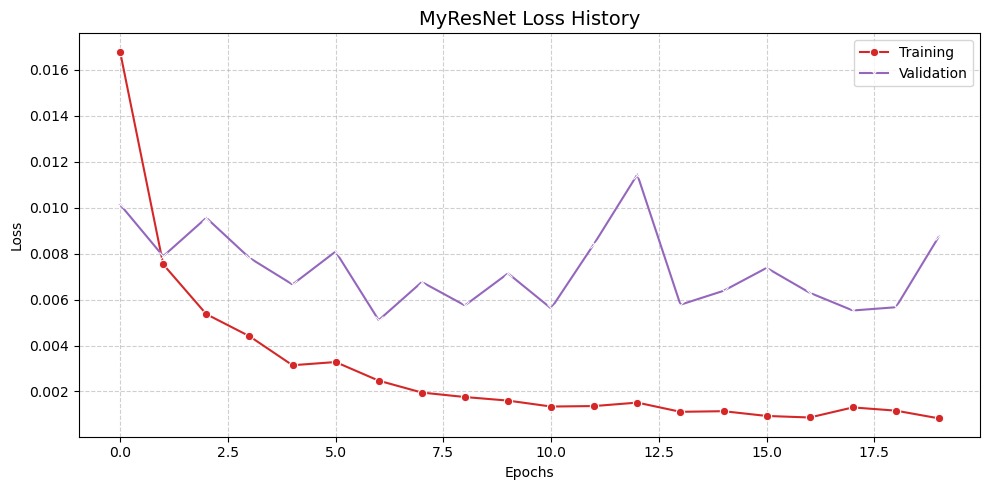

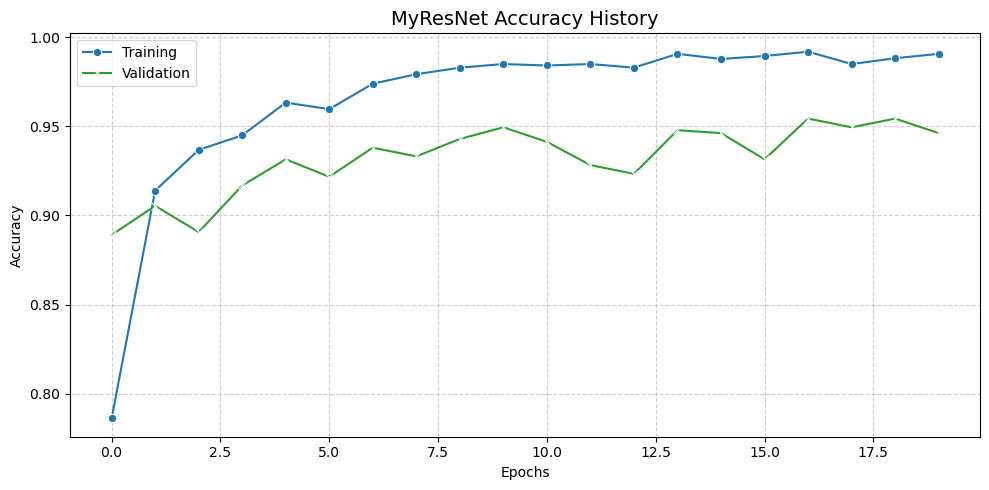

Train Accuracy = 0.990616075241629; Validation Accuracy = 0.9461663948770059


In [ ]:
resnet_trainer.plot_loss_history()
resnet_trainer.plot_accuracy()
train_accuracy = resnet_trainer.train_accuracy_history[-1]
validation_accuracy = resnet_trainer.validation_accuracy_history[-1]
print(
    "Train Accuracy = {}; Validation Accuracy = {}".format(
        train_accuracy, validation_accuracy
    )
)

In [ ]:
save_trained_model_weights(model_resnet, out_dir=os.path.join(model_path, "ResNet"))

Saved training plots to ../src/models/ResNet/trained_MyResNet_final.pt


# Step 3: Test Inception Pretrained Model

In [ ]:
inp_size = (299,299)

In [ ]:
model_inception = MyInception(num_classes=num_classes)

inception_optimizer_config = {"optimizer_type": "adam", "lr": 1e-5, "weight_decay": 1e-8} # Tune these
inception_optimizer = get_optimizer(model_inception, inception_optimizer_config)

inception_trainer = Trainer(
    data_dir=data_path,
    model=model_inception,
    optimizer=inception_optimizer,
    model_dir=os.path.join(model_path, "Inception"),
    train_data_transforms=get_all_transforms(inp_size, [dataset_mean], [dataset_std]),
    val_data_transforms=get_fundamental_normalization_transforms(
        inp_size, [dataset_mean], [dataset_std]
    ),
    batch_size=batch_size,
    load_from_disk=False,
    cuda=torch.cuda.is_available(),
)

In [ ]:
%%time
inception_trainer.run_training_loop(num_epochs=20)

Minibatch:1 Train Loss:0.0342 Val Loss: 0.0342 Train Accuracy: 0.3125 Validation Accuracy: 0.3125


KeyboardInterrupt: 

/Users/willakins/Downloads/project-folder/Git/TumorTrace/TumorTrace/src/runner.py:207: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


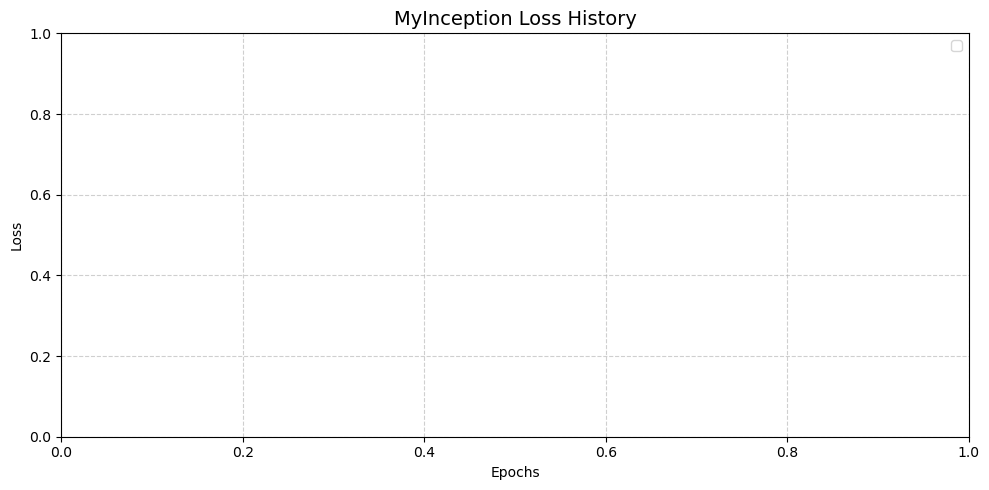

/Users/willakins/Downloads/project-folder/Git/TumorTrace/TumorTrace/src/runner.py:219: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


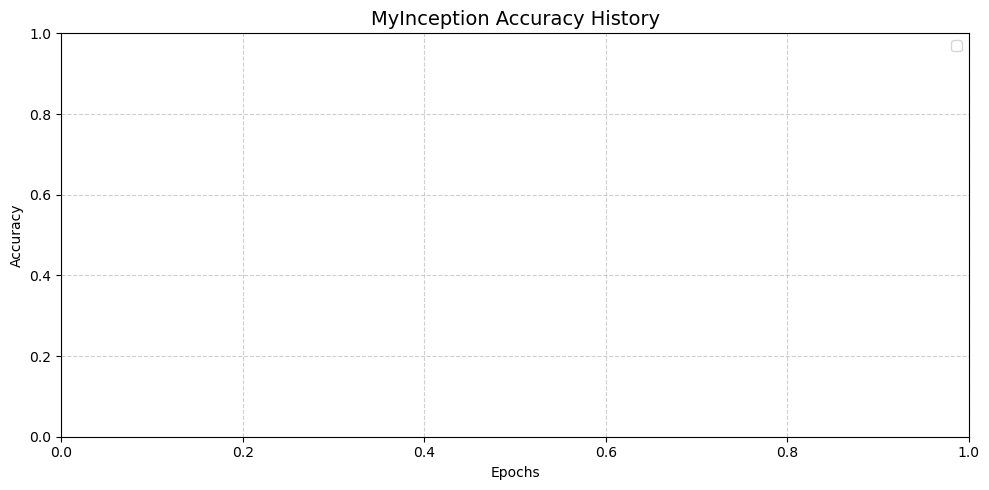

IndexError: list index out of range

In [ ]:
inception_trainer.plot_loss_history()
inception_trainer.plot_accuracy()
train_accuracy = inception_trainer.train_accuracy_history[-1]
validation_accuracy = inception_trainer.validation_accuracy_history[-1]
print(
    "Train Accuracy = {}; Validation Accuracy = {}".format(
        train_accuracy, validation_accuracy
    )
)

In [ ]:
save_trained_model_weights(model_inception, out_dir=os.path.join(model_path, "Inception"))

# Step 4: Analyze Graphs and Final Accuracies

### Model Parameters

In [ ]:
print('3D CNN:', model_cnn.count_parameters())
print('ResNet:', model_resnet.count_parameters())
print('Inception:', model_inception.count_parameters())

### Classification Results

In [ ]:
cnn_trainer.print_classification_report()
resnet_trainer.print_classification_report()
inception_trainer.print_classification_report()

### Loss & Accuracy Graphs

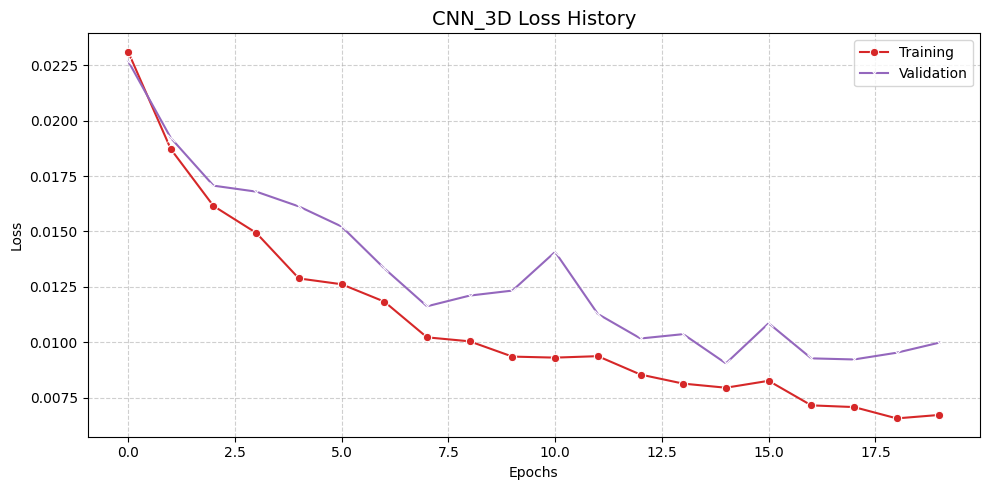

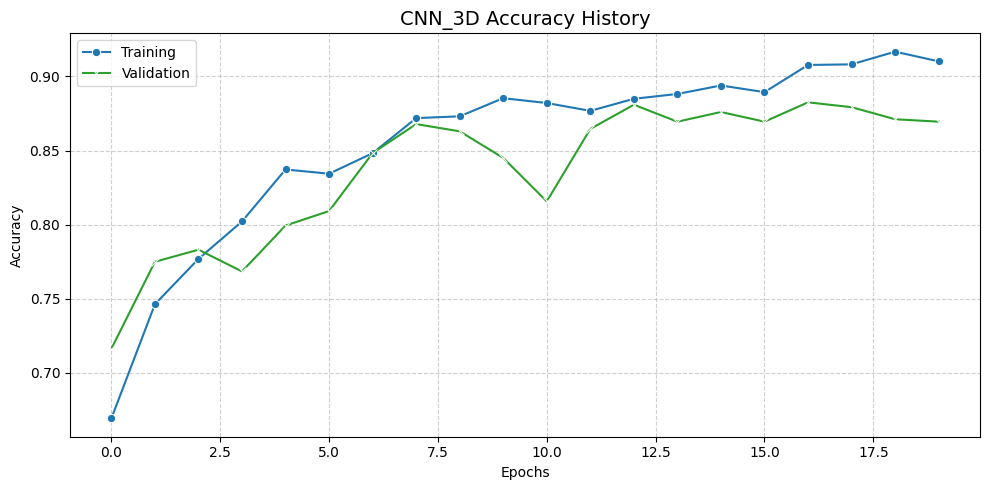

Train Accuracy = 0.9102407182444849; Validation Accuracy = 0.8694942904724382


In [16]:
cnn_trainer.plot_loss_history()
cnn_trainer.plot_accuracy()
train_accuracy = cnn_trainer.train_accuracy_history[-1]
validation_accuracy = cnn_trainer.validation_accuracy_history[-1]
print(
    "Train Accuracy = {}; Validation Accuracy = {}".format(
        train_accuracy, validation_accuracy
    )
)

In [ ]:
resnet_trainer.plot_loss_history()
resnet_trainer.plot_accuracy()
train_accuracy = resnet_trainer.train_accuracy_history[-1]
validation_accuracy = resnet_trainer.validation_accuracy_history[-1]
print(
    "Train Accuracy = {}; Validation Accuracy = {}".format(
        train_accuracy, validation_accuracy
    )
)

In [ ]:
inception_trainer.plot_loss_history()
inception_trainer.plot_accuracy()
train_accuracy = inception_trainer.train_accuracy_history[-1]
validation_accuracy = inception_trainer.validation_accuracy_history[-1]
print(
    "Train Accuracy = {}; Validation Accuracy = {}".format(
        train_accuracy, validation_accuracy
    )
)

### Confusion Matrices

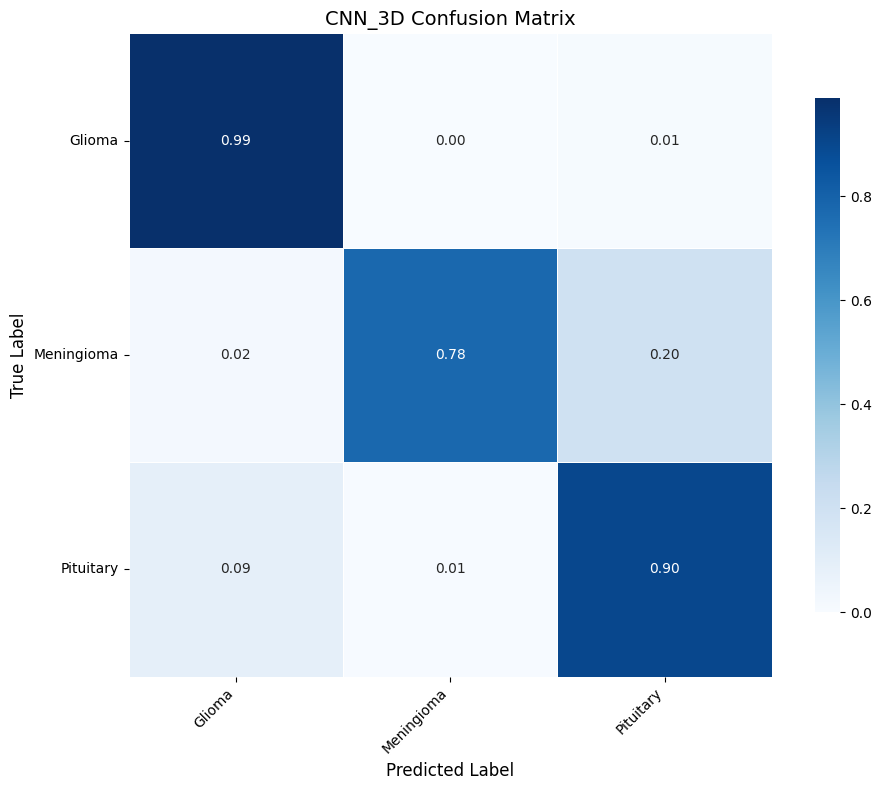

In [17]:
generate_and_plot_confusion_matrix(model_cnn, cnn_trainer.val_dataset, path=results_path, use_cuda=torch.cuda.is_available())

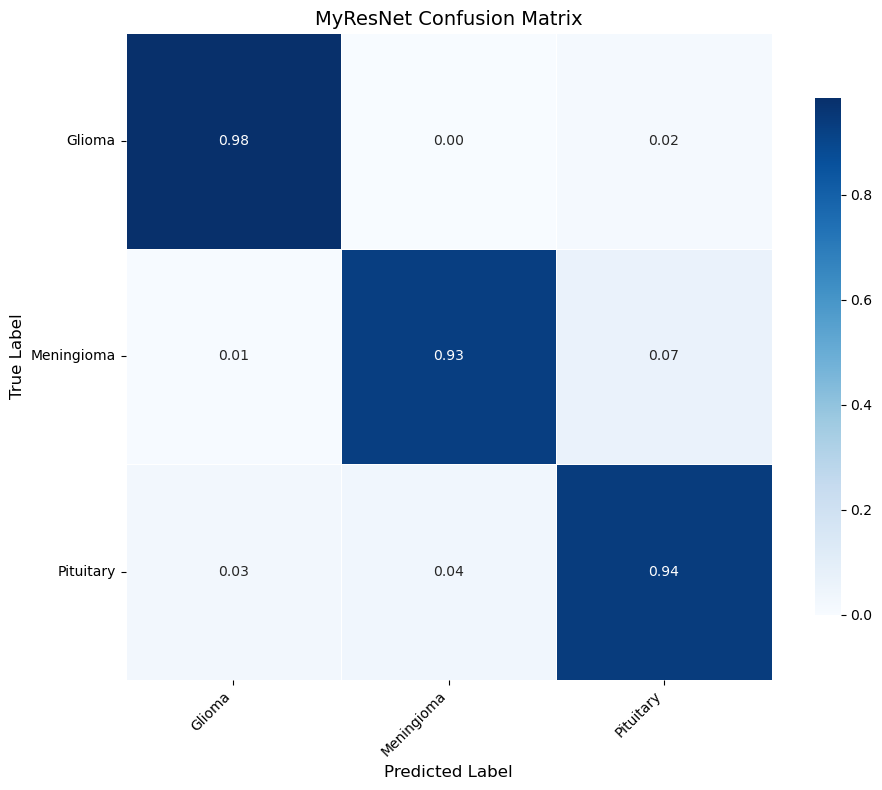

In [ ]:
generate_and_plot_confusion_matrix(model_resnet, resnet_trainer.val_dataset, path=results_path, use_cuda=torch.cuda.is_available())

In [ ]:
generate_and_plot_confusion_matrix(model_inception, inception_trainer.val_dataset, path=results_path, use_cuda=torch.cuda.is_available())

### Analyze errors that occurred from confusion matrix

In [ ]:
trainer = cnn_trainer # Change this
model = model_cnn # Change this

predicted_class_num = 1
true_class_num = 2
correct_class = [k for k, v in trainer.val_dataset.class_dict.items() if v == true_class_num][0]
pred_class = key = [k for k, v in trainer.val_dataset.class_dict.items() if v == predicted_class_num][0]
print(trainer.val_dataset.class_dict)

paths = get_pred_images_for_target(model, trainer.val_dataset, predicted_class_num, true_class_num, torch.cuda.is_available())
max_count = 1
count = 0
for path in paths:
    img = Image.open(path).convert(mode='L')
    if (count != max_count):
        plt.imshow(img, cmap='gray')
        plt.title(f'Image of {correct_class}, misclassified as {pred_class}')
        plt.axis('off')  # Removes axis ticks
        plt.savefig(os.path.join(results_path, f'{model.__class__.__name__}_misclassified.png')),
        plt.show()
        count += 1